# TUGAS MACHINE LEARNING MNIST NUMBER CLASSIFICATION

- **Kelompok** : Machine Learning 2
- **Anggota** :
    - Roy Indra Pratama
    - M. Adib Nabighah
    - Hilman Dwi R
    - Daniel Nicholas

# Import Libraries

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

# Import Datasets

In [31]:
# load data
train_dataset = datasets.MNIST('./train_digit_mnist', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./test_digit_mnist', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

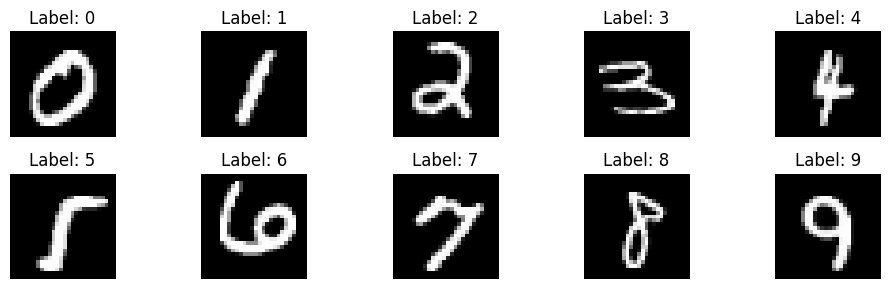

In [32]:
# Get one batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Find indices for each digit (0-9)
digit_indices = {}
for idx, label in enumerate(labels):
    if label.item() not in digit_indices:
        digit_indices[label.item()] = idx
    if len(digit_indices) == 10:
        break

# Plot
plt.figure(figsize=(10, 3))
for digit, idx in digit_indices.items():
    plt.subplot(2, 5, digit+1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title(f"Label: {digit}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Define Custom Loss

In [33]:
def softmax(x):
    e_x = torch.exp(x - torch.max(x, dim=1, keepdim=True).values)
    return e_x / e_x.sum(dim=1, keepdim=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    probabilities = softmax(y_pred)
    
    epsilon = 1e-15
    probabilities = torch.clamp(probabilities, epsilon, 1 - epsilon)
    
    log_likelihood = -torch.log(probabilities[range(n_samples), y_true.argmax(dim=1)])
    loss = log_likelihood.mean()
    return loss

# Model

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

# Train and Evaluate

In [35]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=10).float()
        
        loss = cross_entropy_loss(targets_one_hot, outputs)
        
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            correct += (predicted == targets).sum().item()
    
    print(f'Epoch {epoch+1}, Accuracy: {100 * correct/len(test_dataset):.2f}%')

Epoch 1, Loss: 0.0440
Epoch 1, Accuracy: 98.30%
Epoch 2, Loss: 0.0264
Epoch 2, Accuracy: 98.66%
Epoch 3, Loss: 0.0013
Epoch 3, Accuracy: 98.24%
Epoch 4, Loss: 0.0046
Epoch 4, Accuracy: 99.01%
Epoch 5, Loss: 0.0019
Epoch 5, Accuracy: 99.13%
Epoch 6, Loss: 0.0816
Epoch 6, Accuracy: 99.07%
Epoch 7, Loss: 0.0030
Epoch 7, Accuracy: 98.95%
Epoch 8, Loss: 0.0022
Epoch 8, Accuracy: 99.12%
Epoch 9, Loss: 0.0029
Epoch 9, Accuracy: 99.03%
Epoch 10, Loss: 0.0021
Epoch 10, Accuracy: 99.11%


# Evaluate

In [36]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, prediction = torch.max(outputs, 1)
        all_preds.extend(prediction.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

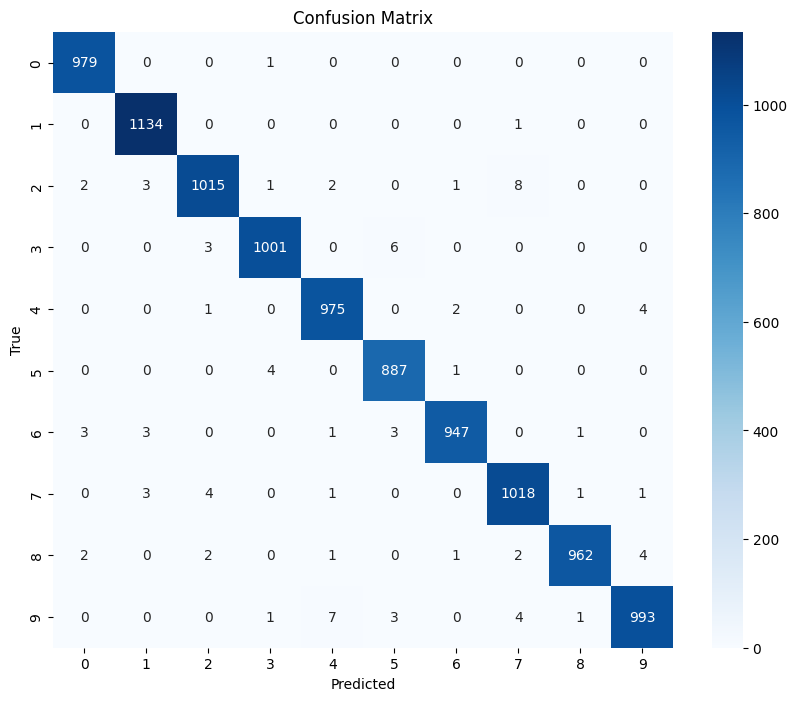

In [37]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
print(classification_report(all_targets, all_preds, target_names=[str(i) for i in range(10)]))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

